<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Analyse_Stationnarit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [1]:
import sys
import pandas

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Chargement d'exemples de séries temporelles

Commençons par charger notre série habituelle :

In [4]:
# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

Puis une série de type "random walk with drift" :

In [42]:
rnd = np.random.RandomState()
y0 = rnd.randn()

y=[]
y.append(y0)

for i in range(0,1459):
  y.append(y[i] + 0.1 + 15*rnd.randn())

Puis du bruit blanc :

In [43]:
rnd = np.random.RandomState()
bb=[]

for i in range(0,1460):
  bb.append( rnd.randn() + 0.1)

Téléchargeons maintenant d'autres exemples :

In [7]:
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/daily-total-female-births-in-cal.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/international-airline-passengers.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/shampoo-sales.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/Sunspots.csv"

Affichons maintenant les séries :

Text(0.5, 1.0, 'Bruit blanc')

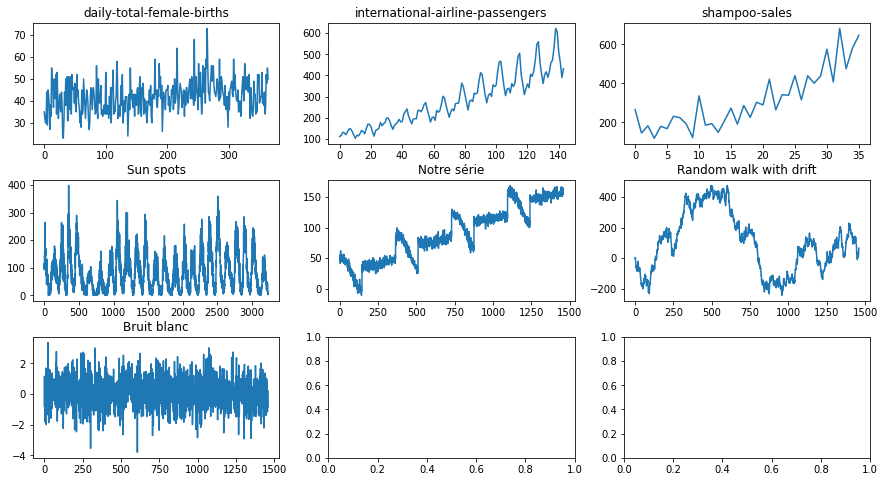

In [45]:
from pandas import Series
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Charge les données en mémoire
fichier1 = 'daily-total-female-births-in-cal.csv'
fichier2 = 'international-airline-passengers.csv'
fichier3 = 'shampoo-sales.csv'
fichier4 = "Sunspots.csv"

serie1 = read_csv(fichier1, usecols=[1], engine='python', skipfooter=2)
serie2 = read_csv(fichier2, usecols=[1], engine='python', skipfooter=2)
serie3 = read_csv(fichier3, usecols=[1], engine='python', skipfooter=2)
serie4 = read_csv(fichier4, usecols=[2], engine='python', skipfooter=2)
serie5 = pandas.Series(serie)
serie6 = pandas.Series(y)
serie7 = pandas.Series(bb)


data1 = serie1.values
data1 = data1.astype('float32')

data2 = serie2.values
data2 = data2.astype('float32')

data3 = serie3.values
data3 = data3.astype('float32')

data4 = serie4.values
data4 = data4.astype('float32')

data5 = serie5.astype('float32')

data6 = serie6.astype('float32')

data7 = serie7.astype('float32')


# Affiche les données
f1, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

serie1.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False)
ax1.set_title('daily-total-female-births')

serie2.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False)
ax2.set_title('international-airline-passengers')

serie3.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False)
ax3.set_title('shampoo-sales')

serie4.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False)
ax4.set_title('Sun spots')

serie5.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False)
ax5.set_title('Notre série')

serie6.plot(subplots=True, ax=ax6, legend=False, sharex=False, sharey=False)
ax6.set_title('Random walk with drift')

serie7.plot(subplots=True, ax=ax7, legend=False, sharex=False, sharey=False)
ax7.set_title('Bruit blanc')



# Méthodes permettant de vérifier l'aspect aléatoire des séries temporelles

**1. Vérification de l'aspect aléatoire des séries par Lag Plot**

Le but est ici d'afficher l'évolution de la série à l'instant (t+nt) en fonction de l'instant précédent : s(t+nt) en fonction de s(t).

Par exemple, si on affiche s(t+1) en fonction de s(t) on utilise un lag plot d'ordre 1.

Si un motif se dessine, cela signifie que la série n'est pas aléatoire. Si le motif qui se dessine est linéaire, cela suggère qu'il existe une autocorrelation.

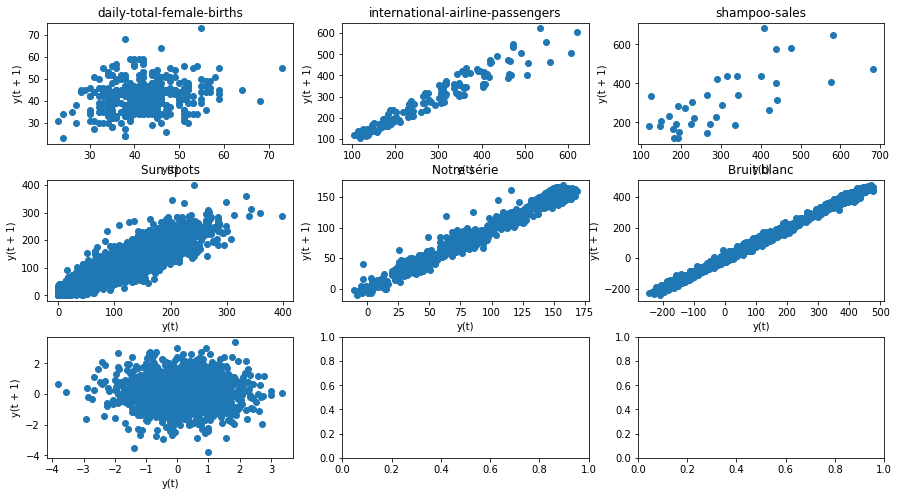

In [48]:
from pandas.plotting import lag_plot

f1, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

# Aléatoire
lag_plot(serie1, ax=ax1)
ax1.set_title('daily-total-female-births');

# Auto-corrélée
lag_plot(serie2, ax=ax2)
ax2.set_title('international-airline-passengers');

# Aléatoire avec un peu d'auto-correlation
lag_plot(serie3, ax=ax3)
ax3.set_title('shampoo-sales');


lag_plot(serie4, ax=ax4)
ax4.set_title('Sun spots');

# Auto-corrélée
lag_plot(serie5, ax=ax5)
ax5.set_title('Notre série');

# Auto-corrélée
lag_plot(serie6, ax=ax6)
ax6.set_title('Random walk with drift');

# Auto-corrélée
lag_plot(serie7, ax=ax7)
ax6.set_title('Bruit blanc');

plt.show()

**2. Vérification de l'aspect aléatoire des séries par auto-corrélation**

Le fait qu'il existe une corrélation entre deux variables indique une dépendance entre elles.  


L'objectif est ici de calculer les autocorrélations pour différentes valeurs de décalage.
Si la série est aléatoire, alors le résultat devrait être proche de zéro. Sinon, certaines des autocorrélations seront très différentes de zéro.  
  
  Les lignes horizontales représentent les bandes de confiances à 95% du niveau critique de corrélation (99% pour les lignes en pointillés) : Les résultats de l'autocorrélation qui sont dans ces bandes nous disent qu'il y a 95% de chance que la série soit non corrélée pour la valeur de ce décalage.  
  Les séries les plus aléatoires vont donc être celles qui auront le plus de résultats à l'intérieur de ces bandes de confiance.

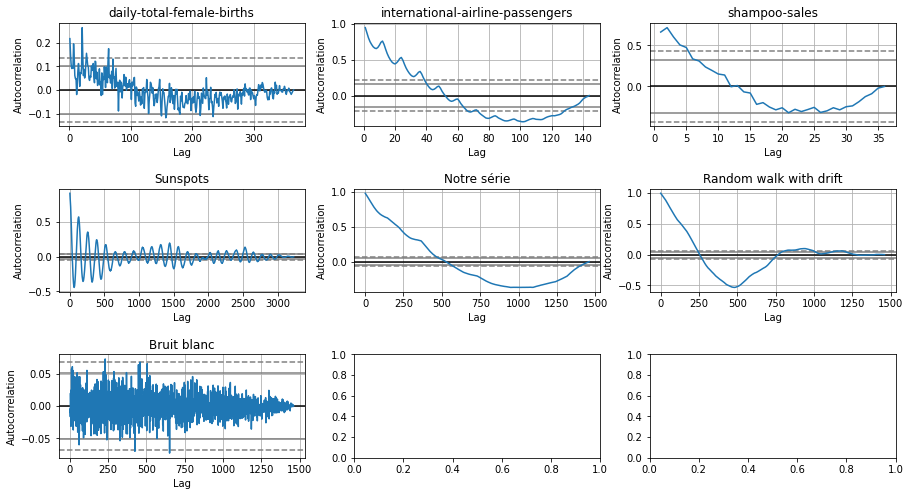

In [54]:
from pandas.plotting import autocorrelation_plot

f1, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.6,wspace=0.2)

# Série très peu corrélée
autocorrelation_plot(serie1, ax=ax1)
ax1.set_title('daily-total-female-births');

# Série fortement corrélée
autocorrelation_plot(serie2, ax=ax2)
ax2.set_title('international-airline-passengers');

# Série très peu corrélée
autocorrelation_plot(serie3, ax=ax3)
ax3.set_title('shampoo-sales');

# Série un peu corrélée
autocorrelation_plot(serie4, ax=ax4)
ax4.set_title('Sunspots');

# Série fortement corrélée
autocorrelation_plot(serie5, ax=ax5)
ax5.set_title('Notre série');

# Série fortement corrélée
autocorrelation_plot(serie6, ax=ax6)
ax6.set_title('Random walk with drift');

# Série fortement corrélée
autocorrelation_plot(serie7, ax=ax7)
ax7.set_title('Bruit blanc');

plt.show()

**3. Utilisation de la librairie Statsmodels : ACF**

  Si nous faisons l'hypothèse que les variables possèdent une distribution de type gaussienne (loi normale), nous pouvons utiliser le **coefficient de corrélation de Pearson** pour quantifier la corrélation entre ces variables.  
  
  Ce coefficient est une valeur comprise entre -1 et 1 qui indique une corrélation négative ou positive. Une valeur nulle indique une absence de corrélation.  
    
  La corrélation sur une série temporelle peut se faire en observant les valeurs à l'instant présent avec les valeurs aux instants précédents, appellés **décalages**. Lorsque la corrélation est calculer sur deux valeurs appartenant à la même série, on dit qu'il s'agit d'une **autocorrélation**.
    
    
Le graphique de l'autocorrélation d'une série temporelle avec décalage s'appelle une **fonction d'autocorrélation** (**ACF** - AutoCorrelation Function).  

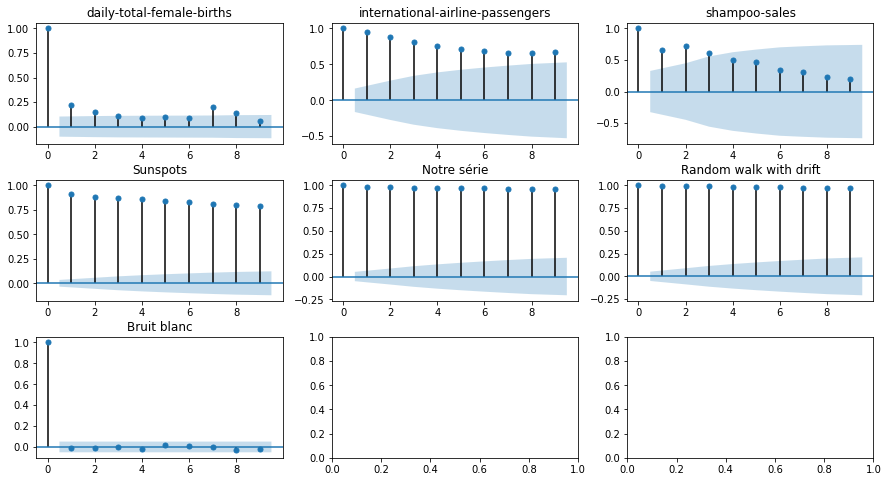

In [50]:
from statsmodels.graphics.tsaplots import plot_acf

f1, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie1, ax=ax1, lags = range(0,10))
ax1.set_title('daily-total-female-births')

plot_acf(serie2, ax=ax2, lags = range(0, 10))
ax2.set_title('international-airline-passengers')

plot_acf(serie3, ax=ax3, lags = range(0, 10))
ax3.set_title('shampoo-sales')

plot_acf(serie4, ax=ax4, lags = range(0, 10))
ax4.set_title('Sunspots')

plot_acf(serie5, ax=ax5, lags = range(0, 10))
ax5.set_title('Notre série')

plot_acf(serie6, ax=ax6, lags = range(0, 10))
ax6.set_title('Random walk with drift')

plot_acf(serie7, ax=ax7, lags = range(0, 10))
ax7.set_title('Bruit blanc')


plt.show()

Les intervalles de confiance à 95% sont cette fois-ci dessinés sous forme de cônes.  
  
  Les valeurs successives des autocorrélations peuvent être fortements corrélées, et donc une valeur particulière peut être grande uniquement parce qu'elle est corrélée très fortement avec la valeur précédente. La forme conique de l'intervalle de confiance vient du fait que cet intervalle prend en compte ces possibilités, et donc ajuste les valeurs critiques en fonction des valeurs d'autocorrélation précédentes. 
  
  Des valeurs en dehors de ce cône indiquent que les variables sont très certainement corrélées entre elles, pour les décalages indiqués.  

**4. Autocorrélation partielle : PACF**

Une autocorrélation partielle permet d'obtenir une corrélation partielle d'une série temporelle avec ses valeurs précédentes ($s_t$ et $s_{t-k}$) , après prise en compte de tous les autres termes ayant un décalage plus court ($s_{t-1}$, $s_{t-2}$, $s_{t-3}$, ...)  
  
  L'autocorrélation partielle est un outil permettant **d'identifier l'ordre d'un modèle statistique de type autorégressif AR(p)** (un type de modèle statistique utilisé pour modéliser les processus stochastiques dans lequel on fait l'hypothèse que la sortie est une fonction linéaire des sorties précédentes et d'un terme aléatoire). L'autocorrélation partielle est nulle aux décalages supérieurs à p+1.

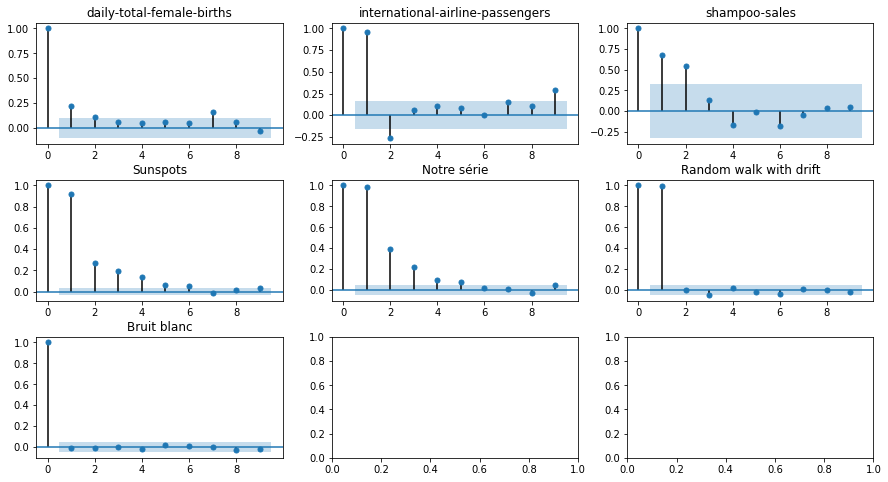

In [52]:
from statsmodels.graphics.tsaplots import plot_pacf

f1, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_pacf(serie1, ax=ax1, lags = range(0,10))
ax1.set_title('daily-total-female-births')

plot_pacf(serie2, ax=ax2, lags = range(0, 10))
ax2.set_title('international-airline-passengers')

plot_pacf(serie3, ax=ax3, lags = range(0, 10))
ax3.set_title('shampoo-sales')

plot_pacf(serie4, ax=ax4, lags = range(0, 10))
ax4.set_title('Sunspots')

plot_pacf(serie5, ax=ax5, lags = range(0, 10))
ax5.set_title('Notre série')

plot_pacf(serie6, ax=ax6, lags = range(0, 10))
ax6.set_title('Random walk with drift')

plot_pacf(serie7, ax=ax7, lags = range(0, 10))
ax7.set_title('Bruit blanc')

plt.show()